In [1]:
from flask_login import current_user
import visual_library_plos as vl
import simplejson
from urllib.parse import urlencode
from urllib.request import urlopen
from io import StringIO
from contextlib import closing
from sklearn import preprocessing
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import numpy as np
from app import app, tokenize, exclude, stopwords, MINDF
from db.db_get_data import get_dc_data

# import argparse
# import sys
# import operator
import math

# import gzip
# import random
import os
import time

time.clock = time.time
from datetime import datetime
from datetime import timedelta
from collections import defaultdict
import json

import pysolr
# from elasticsearch import Elasticsearch

# es = Elasticsearch()
import cluster_pymedAPI
import es_search
from generate_summary import generate_summary

import logging
# Set logging level to suppress debug/info logs
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logging.getLogger("httpcore").setLevel(logging.WARNING)

Reading stopwords...


DEBUG:git.cmd:Popen(['git', 'version'], cwd=/Users/aravind/Documents/LAIR Hub/CODE_v2/pattie_aravind, stdin=None, shell=False, universal_newlines=False)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/Users/aravind/Documents/LAIR Hub/CODE_v2/pattie_aravind, stdin=None, shell=False, universal_newlines=False)


/Users/aravind/Documents/LAIR Hub/CODE_v2/pattie_aravind


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [2]:
import psycopg2
from psycopg2.extras import RealDictCursor
from psycopg2.extras import execute_values

def execute_query_with_params(query, param):
    try:
        hostname = 'localhost'
        port = 5433
        database = 'PATTIE'
        username = 'postgres'
        password = 'Arvi1308'  # replace with your actual password
        # hostname = '34.133.177.246'
        # port = 5432
        # database = 'rss_feed'
        # username = 'aravind'
        # password = 'C&99Fk6xHxypA2R$C4XQ'
        # Establishing the connection
        conn = psycopg2.connect(
            host=hostname,
            port=port,
            dbname=database,
            user=username,
            password=password
        )

        # Create a cursor object using RealDictCursor to get results as dictionaries
        cur = conn.cursor(cursor_factory=RealDictCursor)

        # Execute the query
        cur.execute(query, param)

        # Fetch all the results
        results = cur.fetchall()

        # Close the cursor and the connection
        cur.close()
        conn.close()

        # Return the results
        return results, None

    except Exception as e:
        print(f"An error occurred: {e}")
        if conn:
            conn.close()
        return [], e


In [3]:
def execute_query(query):
    try:
        hostname = 'localhost'
        port = 5433
        database = 'PATTIE'
        username = 'postgres'
        password = 'Arvi1308'  # replace with your actual password
        # hostname = '34.133.177.246'
        # port = 5432
        # database = 'rss_feed'
        # username = 'aravind'
        # password = 'C&99Fk6xHxypA2R$C4XQ'
        # Establishing the connection
        conn = psycopg2.connect(
            host=hostname,
            port=port,
            dbname=database,
            user=username,
            password=password
        )

        # Create a cursor object using RealDictCursor to get results as dictionaries
        cur = conn.cursor(cursor_factory=RealDictCursor)

        # Execute the query
        cur.execute(query)

        # Fetch all the results
        results = cur.fetchall()

        # Close the cursor and the connection
        cur.close()
        conn.close()

        # Return the results
        return results, None

    except Exception as e:
        print(f"An error occurred: {e}")
        if conn:
            conn.close()
        return [], e
    
def retrieve_data(q):
    try:
        hostname = 'localhost'
        port = 5433
        database = 'PATTIE'
        username = 'postgres'
        password = 'Arvi1308'  
        # hostname = '34.133.177.246'
        # port = 5432
        # database = 'rss_feed'
        # username = 'aravind'
        # password = 'C&99Fk6xHxypA2R$C4XQ'
        # query = """
        #         SELECT * FROM papers
        #         WHERE authors @> %s;
        #         """
        query = """
                SELECT * FROM papers
                WHERE EXISTS (
                    SELECT 1 FROM jsonb_array_elements_text(authors) AS author_name
                    WHERE author_name ILIKE %s
                );
                """
        # params = [json.dumps([q])]
        params = [f"%{q}%"]
        data, error = execute_query_with_params(query, params)
        # Convert the data to a DataFrame
        data = pd.DataFrame(data)
        # print(data)
        return data, error
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], e


# data, error = retrieve_data("Bela Gipp")
# # data, error = retrieve_data("S. Harding")
# data

In [4]:
# Function to search the database by keyword in title or description
def search_database_by_keyword(keyword, 
                                hostname = '34.133.177.246',
                                port = 5432,
                                database = 'rss_feed',
                                username = 'aravind',
                                password = 'C&99Fk6xHxypA2R$C4XQ'):
    try:
        # Connect to the database
        connection = psycopg2.connect(host=hostname, port=port, dbname=database, user=username, password=password)
        
        # Create a cursor
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        
        # Format the keyword for full-text search
        formatted_keyword = ' & '.join(keyword.split())

        # Execute the query
        cursor.execute("""
            SELECT * FROM rss_feed
            WHERE to_tsvector('english', title || ' ' || description) @@ to_tsquery('english', %s);
            """, (formatted_keyword,))
        
        # Fetch all the results
        results = cursor.fetchall()

        # Convert the results to a DataFrame
        results = pd.DataFrame(results)
        
        # Close the cursor and connection
        cursor.close()
        connection.close()

        return results, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], e

# # Example Usage
# hostname = '34.133.177.246'
# port = 5432
# database = 'rss_feed'
# username = 'aravind'
# password = 'C&99Fk6xHxypA2R$C4XQ'

# # Search data by keyword
# keyword_data, error = search_database_by_keyword("ronaldo", hostname, port, database, username, password)
# if not error:
#     # Print number of results
#     print(f"Number of results: {len(keyword_data)}")


In [5]:
def read_df(dataframe, dataset, stopwords=[]):
    print("Reading dataframe...")
    doc_term_mat = []  # store documents
    df = dict()  # document frequency
    w2id = dict()
    cnt_w = 0
    bibs = []
    if dataset == "PubMedAPI":
        for index, row in dataframe.iterrows():
            string = ''
            bibs_dict = {}
            if 'pmid' in dataframe:
                pmid_ = str(row['pmid'])
                bibs_dict['pmid'] = pmid_
            if 'title' in dataframe:
                # print('title in dataframe')
                title_ = str(row['title'])
                bibs_dict['title'] = title_
                string = string + title_.lower() + ' '
            if 'author' in dataframe:
                # print('author in dataframe')
                author_ = str(row['author'])
                bibs_dict['author'] = author_
            if 'authors' in dataframe:
                # print('author in dataframe')
                author_ = row['authors']
                bibs_dict['author'] = author_
            if 'affiliations' in dataframe:
                # print('affiliation dataframe')
                affiliation_ = row['affiliations']
                bibs_dict['affiliations'] = affiliation_
            if 'source' in dataframe:
                source_ = str(row['source'])
                bibs_dict['journal'] = source_
            if 'abstract' in dataframe:
                # print('abstract in dataframe')
                abstract_ = str(row['abstract'])
                # TAG: for gene coverage testing
                bibs_dict['abstract'] = abstract_
                string = string + abstract_.lower() + ' '
            if 'description' in dataframe:
                # print("description in dataframe")
                description_ = str(row['description'])
            if 'snippet' in dataframe:
                # print("description in dataframe")
                description_ = str(row['snippet'])
                # bibs_dict['description']=description_
                string = string + description_.lower() + ' '
            if 'content' in dataframe:
                content_ = str(row['content'])
                # bibs_dict['content']=content_
                string = string + content_.lower() + ' '
            if 'url' in dataframe:
                url_ = str(row['url'])
                bibs_dict['html'] = url_
            if 'pubdate' in dataframe:
                pubdate_ = str(row['pubdate'])
                bibs_dict['pubdate'] = pubdate_
            if 'pubYear' in dataframe:
                pubYear_ = str(row['pubYear'])
                bibs_dict['pubYear'] = pubYear_
            if 'journal' in dataframe:
                journal_ = str(row['journal'])
                bibs_dict['journal'] = journal_
            if 'journal_abbrev' in dataframe:
                journalabbrev_ = str(row['journal_abbrev'])
                bibs_dict['journal_abbrev'] = journalabbrev_
            if 'volume' in dataframe:
                volume_ = str(row['volume'])
                bibs_dict['volume'] = volume_
            if 'issue' in dataframe:
                issue_ = str(row['issue'])
                bibs_dict['issue'] = issue_
            if 'doi' in dataframe:
                doi_ = str(row['doi'])
                bibs_dict['doi'] = doi_
            if 'pages' in dataframe:
                pages_ = str(row['pages'])
                bibs_dict['pages'] = pages_
            if 'meshHeadings' in dataframe:
                meshHeadings_ = row['meshHeadings']
                bibs_dict['meshHeadings'] = meshHeadings_

            bibs.append(bibs_dict)
            # print("bibs_dict")
            # print(bibs_dict)
            # print("string is")
            # print(string)
            terms = tokenize.split(string)

            # terms = [lemmatizer.lemmatize(w) for w in terms if w != '' and \
            #             w not in stopwords and \
            #             not exclude.match(w)]

            terms = [w for w in terms if w != '' and
                    w not in stopwords and
                    not exclude.match(w)]
            # count df
            for w in set(terms):
                if w in df:
                    df[w] += 1
                else:
                    df[w] = 1
                    w2id[w] = cnt_w
                    cnt_w += 1
            # count tf
            tf = dict()
            for w in terms:
                if w in tf:
                    tf[w] += 1
                else:
                    tf[w] = 1
            doc_term_mat.append(tf)

    
    elif dataset == "postgres":
        for index, row in dataframe.iterrows():
            string = ''
            bibs_dict = {}
            # if 'paper_id' in dataframe:
            #     paper_id_ = str(row['paper_id'])
            #     bibs_dict['paper_id'] = paper_id_
            # if 'title' in dataframe:
            #     # print('title in dataframe')
            #     title_ = str(row['title'])
            #     bibs_dict['title'] = title_
            #     string = string + title_.lower() + ' '
            # if 'authors' in dataframe:
            #     # print('author in dataframe')
            #     author_ = row['authors']
            #     author_ = [a for a in author_]
            #     bibs_dict['authors'] = author_
            # if 'abstract' in dataframe:
            #     # print('abstract in dataframe')
            #     abstract_ = str(row['abstract'])
            #     # TAG: for gene coverage testing
            #     bibs_dict['abstract'] = abstract_
            #     string = string + abstract_.lower() + ' '
            # if 'url' in dataframe:
            #     url_ = str(row['url'])
            #     bibs_dict['html'] = url_
            # if 'year' in dataframe:
            #     year_ = str(row['year'])
            #     bibs_dict['year'] = year_
            # if 'venue' in dataframe:
            #     venue_ = str(row['venue'])
            #     bibs_dict['venue'] = venue_
            # if 'citation_count' in dataframe:
            #     citation_count_ = str(row['citation_count'])
            #     bibs_dict['citation_count'] = citation_count_
            # if 'fields_of_study' in dataframe:
            #     fields_of_study_ = row['fields_of_study']
            #     fields_of_study_ = [f for f in fields_of_study_]
            #     bibs_dict['fields_of_study'] = fields_of_study_
            # if 'reference_count' in dataframe:
            #     reference_count_ = str(row['reference_count'])
            #     bibs_dict['reference_count'] = reference_count_
            # if 'influential_citation_count' in dataframe:
            #     influential_citation_count_ = str(row['influential_citation_count'])
            #     bibs_dict['influential_citation_count'] = influential_citation_count_
            # if 'publication_types' in dataframe:
            #     publication_types_ = row['publication_types']
            #     publication_types_ = [p for p in publication_types_]
            #     bibs_dict['publication_types'] = publication_types_
            # if 'authors_ids' in dataframe:
            #     authors_ids_ = row['authors_ids']
            #     authors_ids_ = [a for a in authors_ids_]
            #     authors_ids_ = [str(a) for a in authors_ids_]
            #     bibs_dict['authors_ids'] = authors_ids_
            
            if 'paper_id' in dataframe and row['paper_id'] is not None and row['paper_id'] != '':
                paper_id_ = str(row['paper_id'])
                bibs_dict['paper_id'] = paper_id_

            if 'title' in dataframe and row['title'] is not None and row['title'] != '':
                title_ = str(row['title'])
                bibs_dict['title'] = title_
                string = string + title_.lower() + ' '

            if 'authors' in dataframe and row['authors'] is not None and row['authors'] != '':
                author_ = row['authors']
                author_ = [a for a in author_]
                bibs_dict['authors'] = author_

            if 'abstract' in dataframe and row['abstract'] is not None and row['abstract'] != '':
                abstract_ = str(row['abstract'])
                bibs_dict['abstract'] = abstract_
                string = string + abstract_.lower() + ' '

            if 'url' in dataframe and row['url'] is not None and row['url'] != '':
                url_ = str(row['url'])
                bibs_dict['html'] = url_

            if 'year' in dataframe and row['year'] is not None and row['year'] != '':
                year_ = str(row['year'])
                bibs_dict['year'] = year_

            if 'venue' in dataframe and row['venue'] is not None and row['venue'] != '':
                venue_ = str(row['venue'])
                bibs_dict['venue'] = venue_

            if 'citation_count' in dataframe and row['citation_count'] is not None and row['citation_count'] != '':
                citation_count_ = str(row['citation_count'])
                bibs_dict['citation_count'] = citation_count_

            if 'fields_of_study' in dataframe and row['fields_of_study'] is not None and row['fields_of_study'] != '':
                fields_of_study_ = row['fields_of_study']
                fields_of_study_ = [f for f in fields_of_study_]
                bibs_dict['fields_of_study'] = fields_of_study_

            if 'reference_count' in dataframe and row['reference_count'] is not None and row['reference_count'] != '':
                reference_count_ = str(row['reference_count'])
                bibs_dict['reference_count'] = reference_count_

            if 'influential_citation_count' in dataframe and row['influential_citation_count'] is not None and row['influential_citation_count'] != '':
                influential_citation_count_ = str(row['influential_citation_count'])
                bibs_dict['influential_citation_count'] = influential_citation_count_

            if 'publication_types' in dataframe and row['publication_types'] is not None and row['publication_types'] != '':
                publication_types_ = row['publication_types']
                publication_types_ = [p for p in publication_types_]
                bibs_dict['publication_types'] = publication_types_

            if 'authors_ids' in dataframe and row['authors_ids'] is not None and row['authors_ids'] != '':
                authors_ids_ = row['authors_ids']
                authors_ids_ = [str(a) for a in authors_ids_]
                bibs_dict['authors_ids'] = authors_ids_

            bibs.append(bibs_dict)
            # print("bibs_dict")
            # print(bibs_dict)
            # print("string is")
            # print(string)
            terms = tokenize.split(string)
            
            terms = [w for w in terms if w != '' and
                 w not in stopwords and
                 not exclude.match(w)]
            # count df
            for w in set(terms):
                if w in df:
                    df[w] += 1
                else:
                    df[w] = 1
                    w2id[w] = cnt_w
                    cnt_w += 1
            # count tf
            tf = dict()
            for w in terms:
                if w in tf:
                    tf[w] += 1
                else:
                    tf[w] = 1
            doc_term_mat.append(tf)

    
    elif dataset == "rss_feed":
        for index, row in dataframe.iterrows():
            string = ''
            bibs_dict = {}

            if 'title' in dataframe and row['title'] is not None and row['title'] != '':
                title_ = str(row['title'])
                bibs_dict['title'] = title_
                string = string + title_.lower() + ' '

            if 'description' in dataframe and row['description'] is not None and row['description'] != '':
                description_ = row['description']
                description_ = [a for a in description_]
                bibs_dict['description'] = description_


            if 'url' in dataframe and row['url'] is not None and row['url'] != '':
                url_ = str(row['url'])
                bibs_dict['html'] = url_

            bibs.append(bibs_dict)
            # print("bibs_dict")
            # print(bibs_dict)
            # print("string is")
            # print(string)
            terms = tokenize.split(string)
            
            terms = [w for w in terms if w != '' and
                 w not in stopwords and
                 not exclude.match(w)]
            # count df
            for w in set(terms):
                if w in df:
                    df[w] += 1
                else:
                    df[w] = 1
                    w2id[w] = cnt_w
                    cnt_w += 1
            # count tf
            tf = dict()
            for w in terms:
                if w in tf:
                    tf[w] += 1
                else:
                    tf[w] = 1
            doc_term_mat.append(tf)

    return doc_term_mat, df, w2id, bibs

In [6]:
import operator
import math
import copy
from IPython.display import display, HTML
from scipy.sparse import csr_matrix
import visual_library_plos as vl

def compute_tfidf(doc_term_mat, df, rank=5):
    print("Computing tfidf...")

    # print("Does df contains none?")
    # print(None in df)
    # alternative procedure to generate new doc_term_mat copy, avoding using del keyword
    doc_term_mat_ = []
    for d in doc_term_mat:
        d_ = {}
        for w in d:
            if w in df:
                d_[w] = d[w]
        if d_:
            doc_term_mat_.append(d_)
    # doc_term_mat_ = copy.deepcopy(doc_term_mat) # make copy

    dfr = dict()  # df considering only top R terms per document
    for i in range(len(doc_term_mat_)):
        for w in doc_term_mat_[i]:
            doc_term_mat_[i][w] *= math.log(len(doc_term_mat_)/df[w])
        # for w in doc_term_mat[i]:
        #     # delete low DF term
        #     if w not in df:
        #         del doc_term_mat_[i][w]
        #         continue
        #     # tfidf
        #     doc_term_mat_[i][w] *= math.log(len(doc_term_mat)/df[w])

        # Ignore if rank = 0
        if rank > 0:
            # Sort and extract top R terms for this document
            terms_sorted = sorted(doc_term_mat_[i].items(), reverse=True,
                                  key=operator.itemgetter(1))
            top_r = terms_sorted[:rank]

            # Count new df for only top R
            for w, _ in top_r:
                if w in dfr:
                    dfr[w] += 1
                else:
                    dfr[w] = 1

    return doc_term_mat_, dfr

def output_keywords(num_docs, dfr, df, p_docs=0.5, html=False):
    print("Outputting keywords...")
    min_dfr = num_docs * p_docs / 100
    terms_sorted = sorted(dfr.items(), reverse=True,
                          key=operator.itemgetter(1))
    # if not html:
    #     print("term\tDF\tDFR")

    keywords = []
    dfs = []
    dfrs = []
    for w, v in terms_sorted:
        if v < min_dfr:
            break
        if w not in df:
            continue

        keywords.append(w)
        dfs.append(df[w])
        dfrs.append(dfr[w])

        # if not html:
        #     print("%s\t%d\t%d" % (w, df[w], dfr[w]))

    if html:
        d = pd.DataFrame({"Term": keywords, "DF": dfs, "DFR": dfrs},
                         columns=["Term", "DF", "DFR"])
        display(HTML(d.to_html(index=False)))

    return keywords

def update(doc_term_mat, keywords, prev_ids=None):
    print("Updating matrix...")

    if prev_ids == None:
        prev_ids = range(len(doc_term_mat))

    doc_term_mat_new = []
    org_ids = []

    for i, d in enumerate(doc_term_mat):
        h = dict()
        for w in keywords:
            if w in d:
                h[w] = d[w]
                # replace 0 with tiny value to avoid zero division when calculating norm in the future
                if h[w] == 0.0:
                    h[w] = 0.001
        if len(h) > 0:  # exclude doc w/ no terms
            doc_term_mat_new.append(h)
            org_ids.append(prev_ids[i])

    return doc_term_mat_new, org_ids

def convert_sparse(doc_term_mat, keywords):

    # add ids to keywords
    keywords.sort()
    w2id = {c: i for i, c in enumerate(keywords)}

    # Convert to scipy matrix for faster calculation
    data = []
    row_idx = []
    col_idx = []
    for i in range(len(doc_term_mat)):
        data += doc_term_mat[i].values()
        col_idx += [w2id[w] for w in doc_term_mat[i].keys()]
        row_idx += [i] * len(doc_term_mat[i])

    data = csr_matrix((data, (row_idx, col_idx)),
                      (len(doc_term_mat), len(keywords)))

    return data

In [8]:
# def cluster_postgres(raw_query_inp, num_cls_inp):
#     print("cluster")
#     error = None
#     dataset = "postgres"
#     # dataset = "rss_feed"
#     field = "All fields"
#     raw_query = raw_query_inp
#     entity = "keywords"
#     q = raw_query
#     # print(q)
#     num_cls = num_cls_inp
    
#     if dataset == "postgres":
#         print("postgres in routes.py")

#         num_cls = int(num_cls)
#         # data, error = cluster_pymedAPI.retrieve(q)
#         if dataset == "postgres":
#             data, error = retrieve_data(q)
#         elif dataset == "rss_feed":
#             data, error = search_database_by_keyword(q)
#         # Print number of data rows
#         print("Number of data rows: ", len(data))
#         # print(data, error)
#         print(type(data))
#         print(data.columns.tolist())
#         # return data, error
#         if error == None:
#             if entity == "authors":
#                 print("Blah")
            
#             if entity == "keywords":
#                 doc_term_mat, df, w2id, bibs = read_df(data, dataset, stopwords)
        
#         else:
#             print("Error in retrieving data")
#             return None, error
    
#         if dataset !="Experts" and len(bibs) < 5:
#             print("No clusters found, broadening search")
#             return None, None
        
#         if entity != "authors" and dataset != "Experts":
#             print("Computing TDIDF and finding key terms...")
#             # Remove terms whose df is lower than MINDF
#             if MINDF > 0:
#                 inf = []
#                 for w in df:
#                     if df[w] < MINDF:
#                         inf.append(w)
#                 for w in inf:
#                     del df[w]
                    
            
#             # Save org data
#             orig_doc_term_mat = doc_term_mat
#             orig_df = df
            
#             # Compute TFIDF and find key terms
#             # print("Computing TFIDF and finding key terms...")
#             if dataset == "NYTIMES" or dataset == "PLOS" or dataset == "DIABETES":
#                 doc_term_mat, dfr = compute_tfidf(doc_term_mat, df, rank=10)
#             else:
#                 doc_term_mat, dfr = compute_tfidf(doc_term_mat, df, rank=30)
                
#             # Sort and output results (discovered keywords)
#             keywords = output_keywords(len(doc_term_mat), dfr, df, p_docs=1.0)
            
#             # print('Keywords...')
#             # print(keywords)

#             # Create new matrix with the keywords
#             doc_term_mat, org_ids = update(doc_term_mat, keywords)
            
#             # Convert to sparse matrix
#             doc_term_mat = vl.convert_sparse(doc_term_mat, keywords)

#             # Clustering
#             # print()
#             # print("Clustering...")

#             # n_components: number of dimensions for LSA
#             # k: number of clusters
#             # n_desc: number of keywords (desc) for each cluster
            
#             if dataset == "PLOS":
#                     id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
#                         doc_term_mat, keywords, org_ids, n_components=50, k=num_cls, n_desc=25
#                     )
#             else:
#                 id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
#                     doc_term_mat, keywords, org_ids, n_components=20, k=num_cls, n_desc=15
#                 )
            
            
#             if error != None:  # needs to be changed
#                 print(error)
#                 flash(
#                     "Sorry, the entity you've chosen does not generate meaningful clusters for current query. Please try other entities or queries. "
#                 )
#                 return redirect(request.referrer)
            
#         # print("-----------------doc_term_mat-----------------")
#         # print(doc_term_mat)
#         # print("-----------------df-----------------")
#         # print(df)
#         # print("-----------------w2id-----------------")
#         # print(w2id)
#         # print("-----------------bibs-----------------")
#         # print(bibs)
    
    
     
#     if dataset == "rss_feed":
#         print("postgres in routes.py")

#         num_cls = int(num_cls)
#         # data, error = cluster_pymedAPI.retrieve(q)
#         # data, error = retrieve_data(q)
#         data, error = search_database_by_keyword(q)
#         # Print number of data rows
#         print("Number of data rows: ", len(data))
#         # print(data, error)
#         print(type(data))
#         print(data.columns.tolist())
#         # return data, error
#         if error == None:
#             if entity == "authors":
#                 print("Blah")
            
#             if entity == "keywords":
#                 doc_term_mat, df, w2id, bibs = read_df(data, dataset, stopwords)
        
#         else:
#             print("Error in retrieving data")
#             return None, error
    
#         if dataset !="Experts" and len(bibs) < 5:
#             print("No clusters found, broadening search")
#             return None, None
        
#         if entity != "authors" and dataset != "Experts":
#             print("Computing TDIDF and finding key terms...")
#             # Remove terms whose df is lower than MINDF
#             if MINDF > 0:
#                 inf = []
#                 for w in df:
#                     if df[w] < MINDF:
#                         inf.append(w)
#                 for w in inf:
#                     del df[w]
                    
            
#             # Save org data
#             orig_doc_term_mat = doc_term_mat
#             orig_df = df
            
#             # Compute TFIDF and find key terms
#             # print("Computing TFIDF and finding key terms...")
#             if dataset == "NYTIMES" or dataset == "PLOS" or dataset == "DIABETES":
#                 doc_term_mat, dfr = compute_tfidf(doc_term_mat, df, rank=10)
#             else:
#                 doc_term_mat, dfr = compute_tfidf(doc_term_mat, df, rank=30)
                
#             # Sort and output results (discovered keywords)
#             keywords = output_keywords(len(doc_term_mat), dfr, df, p_docs=1.0)
            
#             # print('Keywords...')
#             # print(keywords)

#             # Create new matrix with the keywords
#             doc_term_mat, org_ids = update(doc_term_mat, keywords)
            
#             # Convert to sparse matrix
#             doc_term_mat = vl.convert_sparse(doc_term_mat, keywords)

#             # Clustering
#             # print()
#             # print("Clustering...")

#             # n_components: number of dimensions for LSA
#             # k: number of clusters
#             # n_desc: number of keywords (desc) for each cluster
            
#             if dataset == "PLOS":
#                     id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
#                         doc_term_mat, keywords, org_ids, n_components=50, k=num_cls, n_desc=25
#                     )
#             else:
#                 id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
#                     doc_term_mat, keywords, org_ids, n_components=20, k=num_cls, n_desc=15
#                 )
            
            
#             if error != None:  # needs to be changed
#                 print(error)
#                 flash(
#                     "Sorry, the entity you've chosen does not generate meaningful clusters for current query. Please try other entities or queries. "
#                 )
#                 return redirect(request.referrer)
            
#         # print("-----------------doc_term_mat-----------------")
#         # print(doc_term_mat)
#         # print("-----------------df-----------------")
#         # print(df)
#         # print("-----------------w2id-----------------")
#         # print(w2id)
#         # print("-----------------bibs-----------------")
#         # print(bibs)
    
#     # get cluster colors
#     # center is (.5,.5)
#     cc = np.array(cluster_centers) - 0.5
#     hue = ((np.arctan2(cc[:, 1], cc[:, 0]) / np.pi + 1) * 180).astype(int).tolist()
#     satr = (np.linalg.norm(cc, axis=1) / math.sqrt(2) * 2).tolist()
#     val = [0.8] * num_cls

#     # Create data to pass to result.html
#     df_new = dict()
#     dfr_new = dict()
#     for w in keywords:
#         df_new[w] = df[w]
#         dfr_new[w] = dfr[w]

#     # create adjacency matrix that will be used for network edges
#     centroid_matrix = pd.DataFrame.from_records(cluster_centers)
#     centroid_distances = pd.DataFrame(
#         squareform(pdist(centroid_matrix, metric="euclidean")),
#         columns=list(id2members.keys()),
#         index=list(id2members.keys()),
#     ).to_dict()

#     id2freq = {x: len(id2members[x]) for x in id2members}
    
    
#     # create network data structure
#     # print('\nEUCLIDEAN DISTANCES\n----------')
#     edges = []
#     for i in id2members:
#         for k, v in centroid_distances[i].items():
#             # print(i, ' to ', k, ' = ', v)
#             if i != k:
#                 if v > 0.75:
#                     v = "Distant"
#                     edge = {
#                         "clusterID": i,
#                         "source": cluster_centers[i],
#                         "target": cluster_centers[k],
#                         "distance": v,
#                     }
#                     edges.append(edge)
#                 elif v <= 0.75 and v > 0.50:
#                     v = "Similar"
#                     edge = {
#                         "clusterID": i,
#                         "source": cluster_centers[i],
#                         "target": cluster_centers[k],
#                         "distance": v,
#                     }
#                     edges.append(edge)
#                 elif v <= 0.50:
#                     v = "Very Similar"
#                     edge = {
#                         "clusterID": i,
#                         "source": cluster_centers[i],
#                         "target": cluster_centers[k],
#                         "distance": v,
#                     }
#                     edges.append(edge)

#                 # elif v >= 0.50:
#                 #     v = "Not Similar"
#                 # edge = {"clusterID":i,"source":cluster_centers[i],"target":cluster_centers[k],"distance":v}
#                 # edges.append(edge)
#     sources = []
#     id2meshTerms = {}
    
#     if dataset == "PubMedAPI":
#         from collections import Counter

#         for cluster_id in sorted(id2members.keys()):
#             concepts = cluster_desc[cluster_id]
#             references = []
#             for bib_id in id2members[cluster_id]:
#                 references.append(bibs[bib_id])
#             for paper in references:
#                 if type(paper["author"]) != str and None in paper["author"]:
#                     paper["author"] = [i for i in paper["author"] if i]
#             bibliography = {"concepts": concepts, "references": references}
#             meshTerms = []
#             print("references")
#             print(references)
#             for ref in references:
#                 meshHeadingList = ref.get("meshHeadings")  # ref["meshHeadings"]
#                 for mesh in meshHeadingList:
#                     meshTerms.append(mesh["descriptor"])
#             id2meshTerms[cluster_id] = str(dict(Counter(meshTerms).most_common(20)))
#             sources.append(bibliography)
#         # print(sources)
#     elif dataset == "postgres":
#         for cluster_id in sorted(id2members.keys()):
#             references = []
#             for bib_id in id2members[cluster_id]:
#                 references.append(bibs[bib_id])
#             for paper in references:
#                 if type(paper["authors"]) != str and None in paper["authors"]:
#                     paper["authors"] = [i for i in paper["authors"] if i]
#             bibliography = {"references": references}
#             sources.append(bibliography)
#         print(sources)
        
#     elif dataset == "rss_feed":
#         for cluster_id in sorted(id2members.keys()):
#             references = []
#             for bib_id in id2members[cluster_id]:
#                 references.append(bibs[bib_id])
#             # for paper in references:
#             #     if type(paper["authors"]) != str and None in paper["authors"]:
#             #         paper["authors"] = [i for i in paper["authors"] if i]
#             bibliography = {"references": references}
#             sources.append(bibliography)
#         print(sources)
#     # session['doc_term_mat'] = doc_term_mat  # term-doc matrix
#     session = {}
#     session["docs_org"] = orig_doc_term_mat  # doc-term raw freq matrix
#     session["df_org"] = orig_df
#     session["num_cls"] = num_cls
#     session["id2members_0"] = id2members
#     session["cluster_desc_0"] = cluster_desc
#     session["xy_0"] = cluster_centers
#     # session["state"] = state
#     session["hue_0"] = hue
#     session["satr_0"] = satr
#     session["org_ids_0"] = org_ids
#     session["bibs_0"] = bibs
#     session["dataset"] = dataset
#     session["edges_0"] = edges
#     session["sources"] = sources
#     session["id2meshTerms"] = id2meshTerms
    
    
#     session["entity"] = entity
#     if entity == "authors":
#         session["author_names"] = author_names
#         session["author_docs"] = author_docs
        
#     # Convert NumPy arrays to lists
#     def convert_ndarray_to_list(obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         elif isinstance(obj, list):
#             return [convert_ndarray_to_list(item) for item in obj]
#         elif isinstance(obj, dict):
#             return {key: convert_ndarray_to_list(value) for key, value in obj.items()}
#         else:
#             return obj

#     # Ensure orig_doc_term_mat is a list
#     orig_doc_term_mat_list = convert_ndarray_to_list(orig_doc_term_mat)
#     # Ensure orig_df is a list or dict (depending on its original type)
#     orig_df_list = convert_ndarray_to_list(orig_df)
#     # Ensure cluster_centers is a list
#     cluster_centers_list = convert_ndarray_to_list(cluster_centers)
#     # Ensure coordinates is a list
#     coordinates_list = convert_ndarray_to_list(coordinates)
    
    
#     sessionData = {
#         "docs_org": convert_ndarray_to_list(orig_doc_term_mat),  # doc-term raw freq matrix
#         "df_org": convert_ndarray_to_list(orig_df),
#         "num_cls": num_cls,
#         "id2members_0": convert_ndarray_to_list(id2members),
#         "cluster_desc_0": convert_ndarray_to_list(cluster_desc),
#         "xy_0": convert_ndarray_to_list(cluster_centers),
#         # "state": state,
#         "hue_0": convert_ndarray_to_list(hue),
#         "satr_0": convert_ndarray_to_list(satr),
#         "org_ids_0": convert_ndarray_to_list(org_ids),
#         "dataset": dataset,
#         "edges_0": convert_ndarray_to_list(edges),
#         "sources": convert_ndarray_to_list(sources)
#     }

#     # session['df'] = df_new
#     # session['dfr'] = dfr_new
#     # session['keywords'] = keywords

#     # print("bibs")
#     # print(bibs)

#     # output the data to terminal
#     print('\nCENTROIDS\n----------')
#     print(cluster_centers)
#     print('\nCENTROID DISTANCES\n----------')
#     print(centroid_distances)
#     print('\nCLUSTER LABELS\n----------')
#     print(cluster_desc)
#     print('\nCLUSTER ID & PUBLICATIONS\n----------')
#     print(id2members)
#     print('\nCLUSTER ID & PUBLICATION COUNT\n----------')
#     print(id2freq)
#     print('\nNETWORK\n----------')
#     print(edges)
    
#     # Generate summaries for each cluster
#     cluster_summary = {}
#     cluster_assigned = {}
#     for cluster_id in sorted(id2members.keys()):
#         publications = id2members[cluster_id]
#         pub_texts = "\n".join([f"@article{{{bib_id}, title={bibs[bib_id]['title']}}}" for bib_id in publications])
#         user_content = f"Clustered Publications:\n\n{pub_texts}\n\nAssigned Cluster: '{cluster_desc[cluster_id]}'"
#         # print(f"Cluster {cluster_id} \n\n User Content: {user_content}")
#         summary = generate_summary(user_content)
#         print(f"Cluster {cluster_id}, Assigned Cluster: '{cluster_desc[cluster_id]}'\n\nSummary: {summary}")
#         cluster_summary[cluster_id] = summary
#         cluster_assigned[cluster_id] = cluster_desc[cluster_id]



#     if entity == "authors" or entity == "experts" or entity == "topics":
#         # to tell the difference between keyword search and author search so that sessionStorage won't keep old data when switching between them
#         q = q + "_" + entity

#     print("exit cluster")
#     return sessionData, cluster_summary, cluster_assigned, bibs, cluster_desc
    
        
# sessionData, cluster_summary, cluster_assigned, bibs, cluster_desc = cluster_postgres("Africa", 10)

In [9]:
def cluster_postgres(raw_query_inp, num_cls_inp):
    print("cluster")
    error = None
    dataset = "PostgreSQL"

    field = "All fields"
    raw_query = raw_query_inp
    entity = "keywords"
    q = raw_query
    num_cls = num_cls_inp
    state = 0
    resonse_time = "0"
    send_time = time.clock()
    
    if dataset == "PostgreSQL":
        print("PostgreSQL in routes.py")

        num_cls = int(num_cls)
        # data, error = retrieve_from_postgresql(q)
        data, error = retrieve_data(q)
        print(data, error)
        print(type(data), data.columns.tolist())
        if error == None:
            if entity == "genes":
                doc_term_mat, df, w2id, bibs = vl.read_df_genes(
                    session["gene_set"], data, dataset, stopwords
                )
            elif entity == "authors":
                (
                    orig_doc_term_mat,
                    orig_df,
                    df,
                    dfr,
                    keywords,
                    cluster_centers,
                    cluster_desc,
                    coordinates,
                    id2members,
                    bibs,
                    org_ids,
                    author_names,
                    author_docs,
                ) = vl.process_authors_4(data, dataset, stopwords)
            else:
                doc_term_mat, df, w2id, bibs = vl.read_df(data, dataset, stopwords)
        else:
            print(error)
            return

        if dataset != "Experts" and len(bibs) < 10:
            print("No clusters found. Broaden your search.")
            return

        if entity != "authors" and dataset != "Experts":
            print("Computing TFIDF and finding key terms...")
            if MINDF > 0:
                inf = []
                for w in df:
                    if df[w] <= MINDF:
                        inf.append(w)
                for w in inf:
                    del df[w]

            orig_doc_term_mat = doc_term_mat
            orig_df = df

            if dataset == "NYTIMES" or dataset == "PLOS" or dataset == "DIABETES":
                doc_term_mat, dfr = vl.compute_tfidf(doc_term_mat, df, rank=10)
            else:
                doc_term_mat, dfr = vl.compute_tfidf(doc_term_mat, df, rank=30)

            keywords = vl.output_keywords(len(doc_term_mat), dfr, df, p_docs=1.0)
            doc_term_mat, org_ids = vl.update(doc_term_mat, keywords)
            doc_term_mat = vl.convert_sparse(doc_term_mat, keywords)

            if dataset == "PLOS":
                id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
                    doc_term_mat, keywords, org_ids, n_components=50, k=num_cls, n_desc=25
                )
            else:
                id2members, cluster_centers, cluster_desc, coordinates, error = vl.kmeans(
                    doc_term_mat, keywords, org_ids, n_components=20, k=num_cls, n_desc=15
                )

            if error != None:
                print(error)
                return redirect(request.referrer)

    cc = np.array(cluster_centers) - 0.5
    hue = ((np.arctan2(cc[:, 1], cc[:, 0]) / np.pi + 1) * 180).astype(int).tolist()
    satr = (np.linalg.norm(cc, axis=1) / math.sqrt(2) * 2).tolist()
    val = [0.8] * num_cls

    df_new = dict()
    dfr_new = dict()
    for w in keywords:
        df_new[w] = df[w]
        dfr_new[w] = dfr[w]

    centroid_matrix = pd.DataFrame.from_records(cluster_centers)
    centroid_distances = pd.DataFrame(
        squareform(pdist(centroid_matrix, metric="euclidean")),
        columns=list(id2members.keys()),
        index=list(id2members.keys()),
    ).to_dict()

    id2freq = {x: len(id2members[x]) for x in id2members}

    edges = []
    for i in id2members:
        for k, v in centroid_distances[i].items():
            if i != k:
                if v > 0.75:
                    v = "Distant"
                    edge = {
                        "clusterID": i,
                        "source": cluster_centers[i],
                        "target": cluster_centers[k],
                        "distance": v,
                    }
                    edges.append(edge)
                elif v <= 0.75 and v > 0.50:
                    v = "Similar"
                    edge = {
                        "clusterID": i,
                        "source": cluster_centers[i],
                        "target": cluster_centers[k],
                        "distance": v,
                    }
                    edges.append(edge)
                elif v <= 0.50:
                    v = "Very Similar"
                    edge = {
                        "clusterID": i,
                        "source": cluster_centers[i],
                        "target": cluster_centers[k],
                        "distance": v,
                    }
                    edges.append(edge)
    sources = []
    id2meshTerms = {}
    if dataset == "PostgreSQL":
        from collections import Counter

        for cluster_id in sorted(id2members.keys()):
            concepts = cluster_desc[cluster_id]
            references = []
            print(f'--------{cluster_id}---------')
            for bib_id in id2members[cluster_id]:
                references.append(bibs[bib_id])
            print(references)
            print('-----------------')
            for paper in references:
                if type(paper["author"]) != str and None in paper["author"]:
                    paper["author"] = [i for i in paper["author"] if i]
                    print(paper["author"])
            # Add 'meshHeadings': [] to each reference in references
            for ref in references:
                ref['meshHeadings'] = []
            bibliography = {"concepts": concepts, "references": references}
            meshTerms = []
            for ref in references:
                meshHeadingList = ref.get("meshHeadings")  # ref["meshHeadings"]
                for mesh in meshHeadingList:
                    meshTerms.append(mesh["descriptor"])
            id2meshTerms[cluster_id] = str(dict(Counter(meshTerms).most_common(20)))
            sources.append(bibliography)

    session = {}
    session["docs_org"] = orig_doc_term_mat  # doc-term raw freq matrix
    session["df_org"] = orig_df
    session["num_cls"] = num_cls
    session["id2members_0"] = id2members
    session["cluster_desc_0"] = cluster_desc
    session["xy_0"] = cluster_centers
    session["hue_0"] = hue
    session["satr_0"] = satr
    session["org_ids_0"] = org_ids
    session["bibs_0"] = bibs
    session["dataset"] = dataset
    session["edges_0"] = edges
    session["sources"] = sources
    session["id2meshTerms"] = id2meshTerms

    session["entity"] = entity
    if entity == "authors":
        session["author_names"] = author_names
        session["author_docs"] = author_docs

    def convert_ndarray_to_list(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, list):
            return [convert_ndarray_to_list(item) for item in obj]
        elif isinstance(obj, dict):
            return {key: convert_ndarray_to_list(value) for key, value in obj.items()}
        else:
            return obj

    orig_doc_term_mat_list = convert_ndarray_to_list(orig_doc_term_mat)
    orig_df_list = convert_ndarray_to_list(orig_df)
    cluster_centers_list = convert_ndarray_to_list(cluster_centers)
    coordinates_list = convert_ndarray_to_list(coordinates)
    
    # Generate summaries for each cluster
    cluster_summary = {}
    cluster_assigned = {}
    cluster_title = {}
    for cluster_id in sorted(id2members.keys()):
        publications = id2members[cluster_id]
        pub_texts = "\n".join([f"@article{{{bib_id}, title={bibs[bib_id]['title']}}}" for bib_id in publications])
        # user_content = f"Clustered Publications:\n\n{pub_texts}\n\nAssigned Cluster: '{cluster_desc[cluster_id]}'"
        user_content = f"Clustered Publications:\n\n{pub_texts}'"
        # print(f"Cluster {cluster_id} \n\n User Content: {user_content}")
        print(f"Cluster {cluster_id} \n\n User Content: {user_content}\n\n")
        summary = generate_summary(user_content)
        # Split the string into parts based on the numbering
        print("Preprocessed Summary: ", summary, "\n\n")
        parts = summary.split("2. ")

        summary_title = parts[0].replace("1. ", "").strip()
        summary_val = parts[1].strip()
        print(f"Cluster {cluster_id}, Assigned Cluster: '{cluster_desc[cluster_id]}'\n\nSummary: {summary_val}\n\nTitle: {summary_title}\n\n")
        if 'N/A' in summary_val or 'N/A' in summary_title:
            summary_val = "No summary available due to insufficient paper content"
            summary_title = "No title available"
        cluster_summary[cluster_id] = summary_val
        cluster_assigned[cluster_id] = cluster_desc[cluster_id]
        # If summary title is a sentence, i want it to be a list of words
        summary_title = summary_title.split()
        cluster_title[cluster_id] = summary_title
    cluster_summary_list = [[value] for key, value in cluster_summary.items()]
    cluster_title_list = [[value] for key, value in cluster_title.items()]
    
    
    session["cluster_desc_0"] = cluster_title_list
    
    sessionData = {
        "docs_org": convert_ndarray_to_list(orig_doc_term_mat),  # doc-term raw freq matrix
        "df_org": convert_ndarray_to_list(orig_df),
        "num_cls": num_cls,
        "id2members_0": convert_ndarray_to_list(id2members),
        # "cluster_desc_0": convert_ndarray_to_list(cluster_desc),
        "cluster_desc_0": convert_ndarray_to_list(cluster_title_list),
        "cluster_summary_0": convert_ndarray_to_list(cluster_summary_list),
        "xy_0": convert_ndarray_to_list(cluster_centers),
        "state": state,
        "hue_0": convert_ndarray_to_list(hue),
        "satr_0": convert_ndarray_to_list(satr),
        "org_ids_0": convert_ndarray_to_list(org_ids),
        "dataset": dataset,
        "edges_0": convert_ndarray_to_list(edges),
        "sources": convert_ndarray_to_list(sources)
    }
    
    receive_time = time.clock()
    response_time = str(round(receive_time - send_time, 3))
    

    if entity == "authors" or entity == "experts" or entity == "topics":
        # to tell the difference between keyword search and author search so that sessionStorage won't keep old data when switching between them
        q = q + "_" + entity
    print("state in cluster: ", state)
    print("exit cluster")
    return cluster_summary, cluster_assigned, bibs, cluster_desc, sessionData, response_time

cls_summary, cls_assigned, bibs, cls_desc, sessionData, response_time = cluster_postgres("M. Kirschenbaum", 10)

cluster
PostgreSQL in routes.py
                                    paper_id  \
0   70bb033a48e9e3356565ce540afc0dc3deb3ac9a   
1   1b90ac2eb758a14604ce6e6dc8bb290a8a9610b2   
2   5d7e05186339526db24cd6ed69235d159a9b3503   
3   e9ed1d75eb12ead7091e7d7adb105e4fe146bb67   
4   79b6569df75e34c297b9a223f7e80b4b758c621a   
5   ce6a9fab6fc61654a30eca959fd3e0c54d061c9c   
6   0a293c3eb77931b80b77519df3e8dcce7139507b   
7   a854c08703746717b62572ab08c406fab021e777   
8   a567b97a5de0e681e65d38654b23be2eb578ee90   
9   6a7e13f8f8c5a76ab0700c561d8b972d1fe87e7d   
10  a91d294d77117b06d1532c171c98bd1692adc0f8   
11  a06cc1f1d4f64d855592bcfc42c1e6c82382bb52   
12  e037c370dee528b49514ac5582d7a45b8bba5902   
13  c1c0f0afd487f30cd88f62d4eb9a0765c5c61a3a   
14  89a2a9bbb165aaefa9f3e3a3f06cd3bd39bf9126   
15  e5d5ccc7d66152133907b690d6a03aaa4ef9543f   
16  6556e13272ef4797cea5d8f61d3411d5e00eab4e   
17  0263ed4b795611d3996c7d223aea8483761d740c   
18  7daccf9a37c0c1fce5e50b6ae0b91b4e894dd00d   
19  93dd

/Users/aravind/anaconda3/envs/PATTIE_v2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Extracted 12.0 coordinates
Returning from kmeans
--------0---------
[{'title': '6. Typing on Glass', 'author': ['M. Kirschenbaum'], 'abstract': '', 'html': 'https://www.semanticscholar.org/paper/1b90ac2eb758a14604ce6e6dc8bb290a8a9610b2'}, {'title': '.Txtual Forensics', 'author': ['M. Kirschenbaum'], 'abstract': 'This essay explores David Greethamu2019s notions of u201ctextual forensicsu201d in light of new forms of textual analytics practiced upon born-digital materials. It argues that computers and computational environments ask us to rethink basic evidentiary categories, i.e. u201cinternalu201d vs. u201cexternal,u201d as well as such concepts as normality, agency, and intentionality in relation to textual criticism. In the process u2014 through a forensic examination of one specific piece of digital media u2014 we also learn something about Davidu2019s own personal computing habits.', 'html': 'https://www.semanticscholar.org/paper/e9ed1d75eb12ead7091e7d7adb105e4fe146bb67'}, {'title':

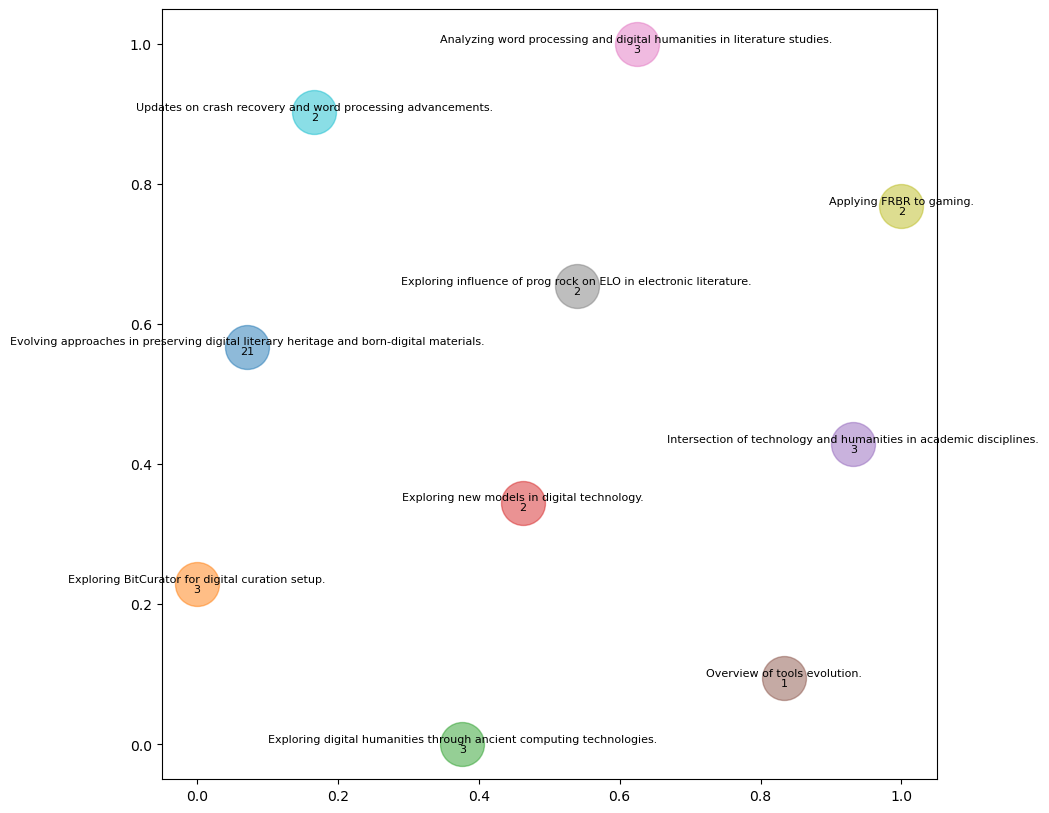

In [12]:
# Matplotlib to plot the clusters
import matplotlib.pyplot as plt
import numpy as np

# Create a bubble chart
def plot_clusters(cluster_centers, cluster_desc, id2members, cluster_summary, cluster_assigned, num_cls):
    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(num_cls):
        x = cluster_centers[i][0]
        y = cluster_centers[i][1]
        ax.scatter(x, y, s=1000, alpha=0.5, label=cluster_desc[i])
        # ax.text(x, y, f"{i+1}", fontsize=12, ha='center', va='center')
        # ax.text(x, y, f"{cluster_desc[i]}", fontsize=8, ha='center', va='bottom')
        # ax.text(x, y, f"{cluster_summary[i]}", fontsize=8, ha='center', va='top')
        # ax.text(x, y, f"{cluster_assigned[i]}", fontsize=8, ha='center', va='bottom')
    # Use the cluster_summary as the label for each cluster
    for i, txt in enumerate(cluster_summary.values()):
        ax.text(cluster_centers[i][0], cluster_centers[i][1], txt, fontsize=8, ha='center', va='bottom')
    # Print number of publications in each cluster
    for i, txt in enumerate(id2members.values()):
        ax.text(cluster_centers[i][0], cluster_centers[i][1], f"{len(txt)}", fontsize=8, ha='center', va='top')
    plt.show()
    
plot_clusters(sessionData["xy_0"], sessionData["cluster_desc_0"], sessionData["id2members_0"], cls_summary, cls_assigned, sessionData["num_cls"])

In [18]:
# sessionData["xy_0"], sessionData["cluster_desc_0"], sessionData["id2members_0"], cls_summary, cls_assigned, sessionData["num_cls"]
sessionData["cluster_desc_0"]

[[['Digital', 'Humanities', 'Trends']],
 [['Digital', 'Curation', 'Workstation']],
 [['Retrocomputing', 'Revival']],
 [['Digital', 'Materialities']],
 [['Digital', 'Humanities', 'Intersection']],
 [['Data-Driven', 'Scholarship', 'Tools']],
 [['Literary', 'Exploration']],
 [['Electronic', 'Literature', 'Lessons']],
 [['FRBR', 'Model', 'on', 'Computer', 'Game']],
 [['Tech', 'Upgrades']]]

In [13]:
cls_summary

{0: 'Evolving approaches in preserving digital literary heritage and born-digital materials.',
 1: 'Exploring BitCurator for digital curation setup.',
 2: 'Exploring digital humanities through ancient computing technologies.',
 3: 'Exploring new models in digital technology.',
 4: 'Intersection of technology and humanities in academic disciplines.',
 5: 'Overview of tools evolution.',
 6: 'Analyzing word processing and digital humanities in literature studies.',
 7: 'Exploring influence of prog rock on ELO in electronic literature.',
 8: 'Applying FRBR to gaming.',
 9: 'Updates on crash recovery and word processing advancements.'}

In [32]:
data.head()

NameError: name 'data' is not defined